## How to use the UniRep mLSTM "babbler". This version demonstrates the 64-unit and the 1900-unit architecture. 

We recommend getting started with the 64-unit architecture as it is easier and faster to run, but has the same interface as the 1900-unit one.

Use the 64-unit or the 1900-unit model?

In [1]:
USE_FULL_1900_DIM_MODEL = False # if True use 1900 dimensional model, else use 64 dimensional one.

## Setup

In [2]:
# to allow autoreload of utils.py
%load_ext autoreload
%autoreload 2

import utils # our functions
import tensorflow as tf
import numpy as np

# Set seeds
tf.set_random_seed(42)
np.random.seed(42)

if USE_FULL_1900_DIM_MODEL:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/1900_weights/ 1900_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./1900_weights"
    
else:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./64_weights"

## Data formatting and management

Initialize UniRep, also referred to as the "babbler" in our code. You need to provide the batch size you will use and the path to the weight directory.

In [3]:
batch_size = 12
b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Code

Initialize database and save in binary files with numpy.save("path to files", data to save)
Once the binary files are created, there is no need to execute this code

In [ ]:
total_start_time = time.time()
classes_avg, classes_concat = utils.dic_init()
total_elapsed_time = time.time() - total_start_time
print(total_elapsed_time)
np.save("dataset/avg/data_avg.npy", classes_avg)
np.save("dataset/concat/data_concat.npy", classes_concat)

dist_intra_avg, stats_intra_avg = utils.get_dist_intra(classes_avg)
dist_intra_concat, stats_intra_concat = utils.get_dist_intra(classes_concat)
np.save("dataset/avg/dist_intra_avg.npy", dist_intra_avg)
np.save("dataset/concat/dist_intra_concat.npy", dist_intra_concat)
np.save("dataset/avg/stats_intra.npy", stats_intra_avg)
np.save("dataset/concat/stats_intra.npy", stats_intra_concat)

dist_extra_avg, stats_extra_avg = utils.get_dist_extra(classes_avg)
dist_extra_concat, stats_extra_concat = utils.get_dist_extra(classes_concat)
np.save("dataset/avg/dist_extra_avg.npy", dist_extra_avg)
np.save("dataset/concat/dist_extra_concat.npy", dist_extra_concat)
np.save("dataset/avg/stats_extra.npy", stats_extra_avg)
np.save("dataset/concat/stats_extra.npy", stats_extra_concat)

utils.seuil_init()

Load data with numpy.load("path to binary file containing data")

In [4]:
classes_avg = np.load("dataset/avg/data_avg.npy")[()]
dist_intra_avg = np.load("dataset/avg/dist_intra_avg.npy")[()]
dist_extra_avg = np.load("dataset/avg/dist_extra_avg.npy")[()]
stat_intra_avg = np.load("dataset/avg/stats_intra.npy")
seuil_avg = np.load("dataset/avg/seuil.npy")[()]
stat_extra_avg = np.load("dataset/avg/stats_extra.npy")

classes_concat = np.load("dataset/concat/data_concat.npy")[()]
dist_intra_concat = np.load("dataset/concat/dist_intra_concat.npy")[()]
dist_extra_concat = np.load("dataset/concat/dist_extra_concat.npy")[()]
stat_intra_concat = np.load("dataset/concat/stats_intra.npy")
stat_extra_concat = np.load("dataset/concat/stats_extra.npy")

distance intra :
	min : 0.0
	max : 1.0644737482070923
	moyenne : 0.2376458477886284
	ecart-type : 0.12049087982188732
distance extra :
	min : 0.08092200011014938
	max : 0.905153214931488
	moyenne : 0.18032568960476
	ecart-type : 0.05996361578523815


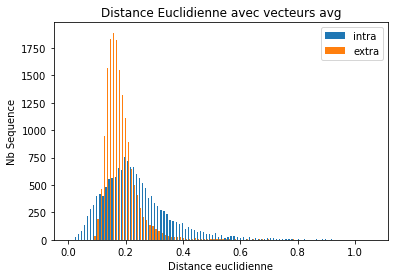

In [7]:
utils.histo(dist_intra_avg, dist_extra_avg, avg = True)

distance intra :
	min : 0.0
	max : 68.86776733398438
	moyenne : 7.875064518503986
	ecart-type : 4.827264943859882
distance extra :
	min : 2.1338412761688232
	max : 66.61040496826172
	moyenne : 4.864801083100704
	ecart-type : 1.9880680914481577


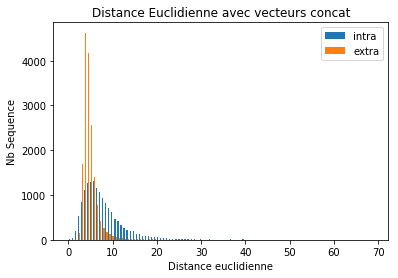

In [8]:
utils.histo(dist_intra_concat, dist_extra_concat, avg = False)

In [41]:
res = np.inf
for distance in dist_intra_avg["a.1.1.1"].values():
    print(distance[1])
    if distance[1] < res:
        res = distance[1]
print(res)
print("-----------")
seuil_intra = np.inf
for protein, distance in dist_intra_avg["a.1.1.1"].values():
    print(distance)
    if distance < seuil_intra:
        seuil_intra = distance
print(seuil_intra)

0.23578718304634094
0.22807882726192474
0.22807882726192474
0.26993411779403687
0.36367663741111755
0.23578718304634094
0.22807882726192474
-----------
0.23578718304634094
0.22807882726192474
0.22807882726192474
0.26993411779403687
0.36367663741111755
0.23578718304634094
0.22807882726192474


In [44]:
utils.seuil_init()

In [46]:
seuil = np.load("dataset/avg/seuil.npy")[()]

In [56]:
utils.test2()

<class 'str'>
